In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error,r2_score
from xgboost import XGBRegressor
import optuna
import shap
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler, StandardScaler

plt.style.use("ggplot")

import warnings
warnings.filterwarnings("ignore")


In [4]:
df = pd.read_csv('D:\JAI\IMDb Movies India.csv.zip',encoding='ISO-8859-1').drop(columns='Name')

df.dropna(inplace=True)
df.head()

,Year,Duration,Genre,Rating,Votes,Director,Actor 1,Actor 2,Actor 3
1,(2019),109 min,Drama,7.0,8,Gaurav Bakshi,Rasika Dugal,Vivek Ghamande,Arvind Jangid
3,(2019),110 min,"Comedy, Romance",4.4,35,Ovais Khan,Prateik,Ishita Raj,Siddhant Kapoor
5,(1997),147 min,"Comedy, Drama, Musical",4.7,827,Rahul Rawail,Bobby Deol,Aishwarya Rai Bachchan,Shammi Kapoor
6,(2005),142 min,"Drama, Romance, War",7.4,"1,086",Shoojit Sircar,Jimmy Sheirgill,Minissha Lamba,Yashpal Sharma
8,(2012),82 min,"Horror, Mystery, Thriller",5.6,326,Allyson Patel,Yash Dave,Muntazir Ahmad,Kiran Bhatia


In [5]:
print(df.shape)
print("-"*60)
print(df.isna().sum())
print("-"*60)
print(df.duplicated().sum())
print("-"*60)
df.info()

(5659, 9)
------------------------------------------------------------
Year        0
Duration    0
Genre       0
Rating      0
Votes       0
Director    0
Actor 1     0
Actor 2     0
Actor 3     0
dtype: int64
------------------------------------------------------------
0
------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
Index: 5659 entries, 1 to 15508
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Year      5659 non-null   object 
 1   Duration  5659 non-null   object 
 2   Genre     5659 non-null   object 
 3   Rating    5659 non-null   float64
 4   Votes     5659 non-null   object 
 5   Director  5659 non-null   object 
 6   Actor 1   5659 non-null   object 
 7   Actor 2   5659 non-null   object 
 8   Actor 3   5659 non-null   object 
dtypes: float64(1), object(8)
memory usage: 442.1+ KB


In [6]:
df.nunique()

Year          91
Duration     174
Genre        376
Rating        83
Votes       2027
Director    2431
Actor 1     1960
Actor 2     2321
Actor 3     2556
dtype: int64

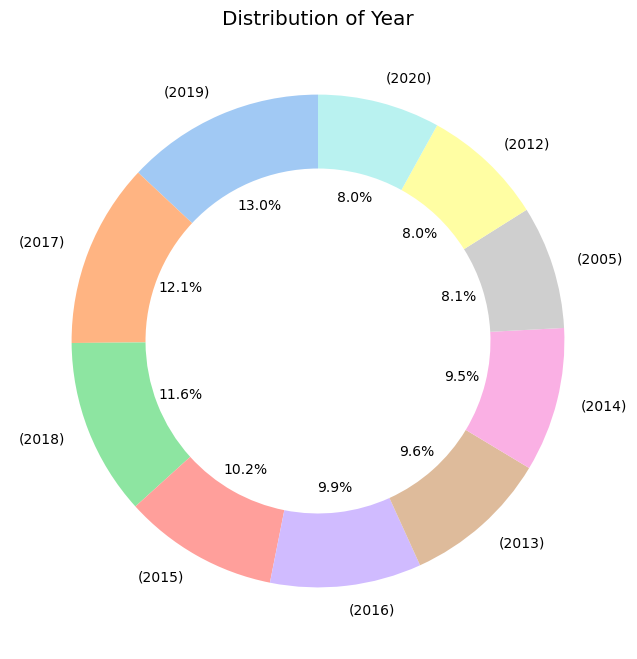

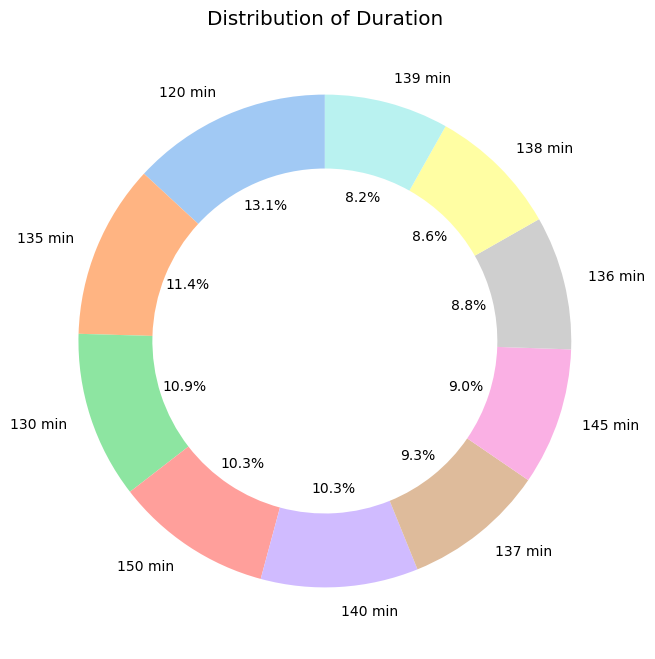

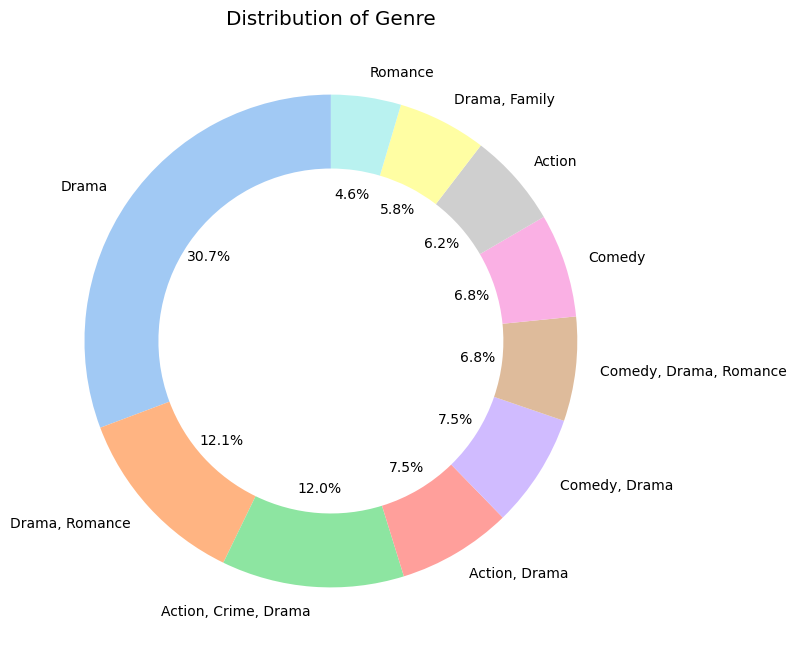

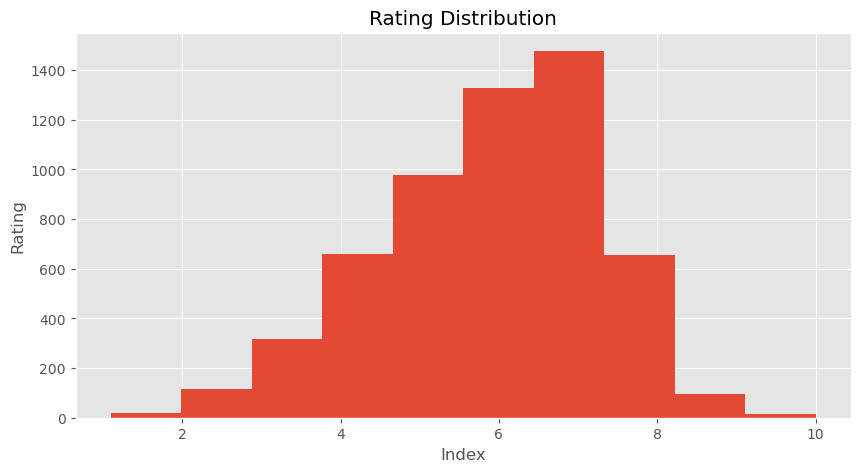

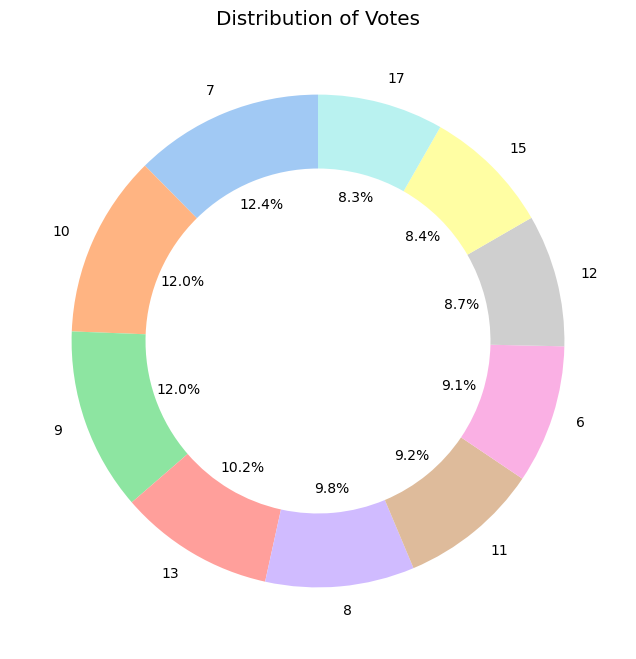

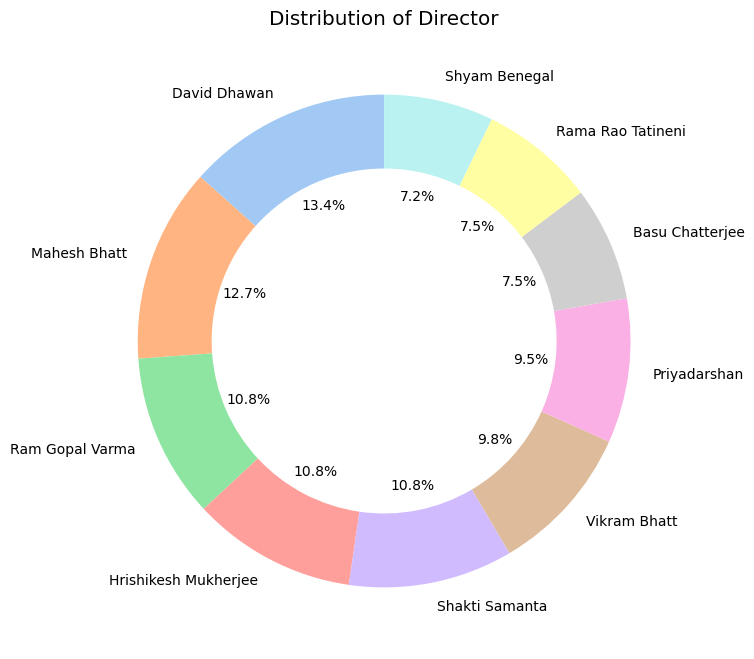

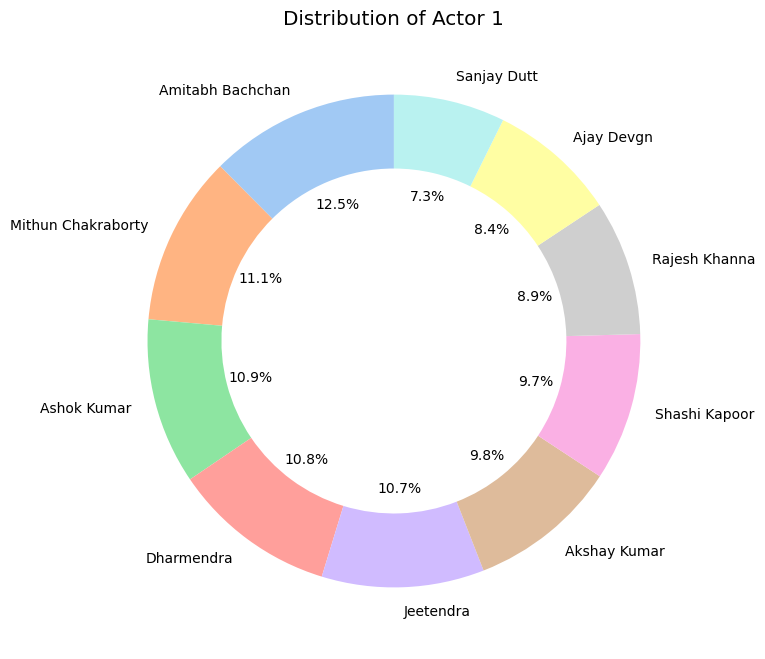

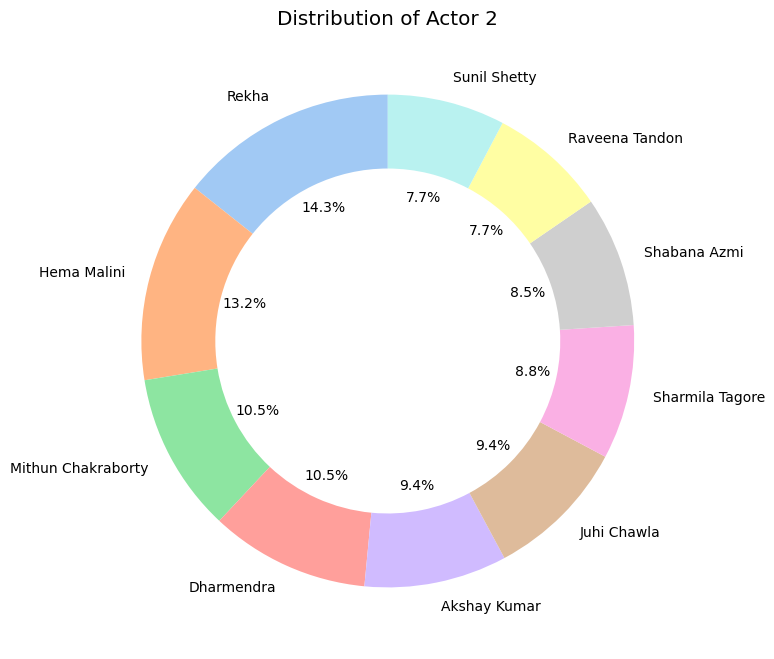

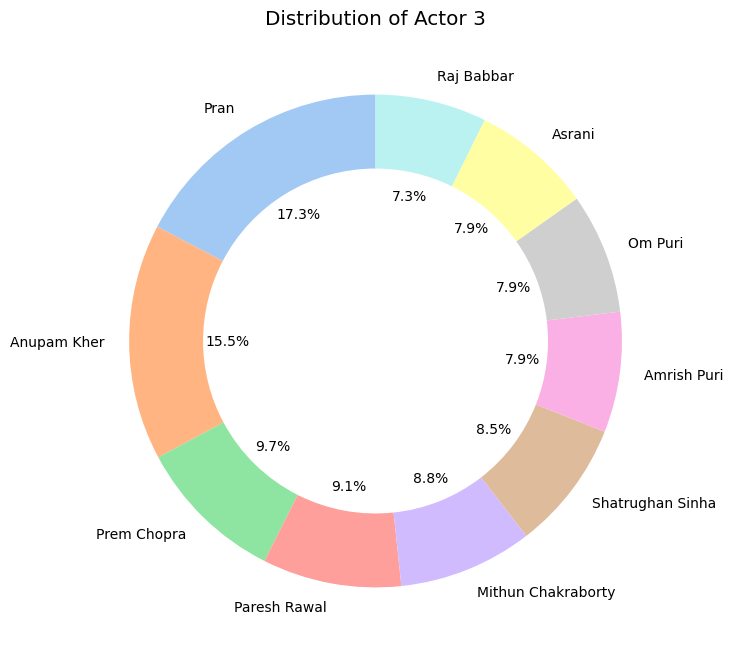

In [7]:
def plot_pie_chart(column):
    plt.figure(figsize=(8, 8))
    df[column].value_counts().head(10).plot.pie(autopct='%1.1f%%', startangle=90, colors=sns.color_palette('pastel'), wedgeprops=dict(width=0.3))
    plt.title(f'Distribution of {column}')
    plt.ylabel('')
    plt.show()
    
    
def plot_hist_chart(column):
    plt.figure(figsize=(10, 5))
    df[column].hist()
    plt.title(f'{column} Distribution')
    plt.xlabel('Index')
    plt.ylabel(column)
    plt.show()

for col in df.columns:
    if df[col].dtype == 'object':
        plot_pie_chart(col)
    else:
        plot_hist_chart(col)

In [8]:
df['Year'] = df['Year'].str.replace('(','')
df['Year'] = df['Year'].str.replace(')','').astype(int)

df['Duration'] = df['Duration'].str.split(' ',expand=True)[0].astype(float)

df['Votes'] = df['Votes'].str.replace(',','').astype(int)

df

,Year,Duration,Genre,Rating,Votes,Director,Actor 1,Actor 2,Actor 3
1,2019,109.0,Drama,7.0,8,Gaurav Bakshi,Rasika Dugal,Vivek Ghamande,Arvind Jangid
3,2019,110.0,"Comedy, Romance",4.4,35,Ovais Khan,Prateik,Ishita Raj,Siddhant Kapoor
5,1997,147.0,"Comedy, Drama, Musical",4.7,827,Rahul Rawail,Bobby Deol,Aishwarya Rai Bachchan,Shammi Kapoor
6,2005,142.0,"Drama, Romance, War",7.4,1086,Shoojit Sircar,Jimmy Sheirgill,Minissha Lamba,Yashpal Sharma
8,2012,82.0,"Horror, Mystery, Thriller",5.6,326,Allyson Patel,Yash Dave,Muntazir Ahmad,Kiran Bhatia
...,...,...,...,...,...,...,...,...,...
15493,2015,115.0,Drama,6.1,408,Mozez Singh,Vicky Kaushal,Sarah Jane Dias,Raaghavv Chanana
15494,2001,153.0,"Biography, Drama, History",6.2,1496,Shyam Benegal,Karisma Kapoor,Rekha,Manoj Bajpayee
15503,1989,125.0,"Action, Crime, Drama",5.8,44,S.P. Muthuraman,Chiranjeevi,Jayamalini,Rajinikanth
15505,1999,129.0,"Action, Drama",4.5,655,Kuku Kohli,Akshay Kumar,Twinkle Khanna,Aruna Irani


In [10]:
director_avg_rating = {}
for index, row in df.iterrows():
    director = row['Director']
    rating = row['Rating']
    if director in director_avg_rating:
        director_avg_rating[director]['sum'] += rating
        director_avg_rating[director]['count'] += 1
    else:
        director_avg_rating[director] = {'sum': rating, 'count': 1}

df['Director Average Rating'] = df['Director'].apply(lambda x: director_avg_rating[x]['sum'] / director_avg_rating[x]['count'])

In [12]:
actor_avg_rating = {}
for index, row in df.iterrows():
    actors = row['Actor 1'].split(', ')
    rating = row['Rating']
    for actor in actors:
        if actor in actor_avg_rating:
            actor_avg_rating[actor]['sum'] += rating
            actor_avg_rating[actor]['count'] += 1
        else:
            actor_avg_rating[actor] = {'sum': rating, 'count': 1}
            
def calculate_lead_actor_average(row):
    actors = row['Actor 1'].split(', ')
    lead_actor_ratings = [actor_avg_rating[actor]['sum'] / actor_avg_rating[actor]['count'] for actor in actors]
    return max(lead_actor_ratings)

df['Lead Actor Average Rating'] = df.apply(calculate_lead_actor_average, axis=1)


In [13]:
df['Genre1'] = df.Genre.str.split(',',expand=True)[0]
df['Genre2'] = df.Genre.str.split(',',expand=True)[1]
df['Genre3'] = df.Genre.str.split(',',expand=True)[2]
df = df.drop(columns=['Genre','Director','Actor 1','Actor 2','Actor 3'])
df.shape[0]

5659

In [14]:
print(df.shape)
print(df.isna().sum())
df = df.fillna(0)

for i in df.index:
    if df.at[i, 'Genre2'] == 0:
        df.at[i, 'Genre2'] = df.at[i, 'Genre1']
    elif df.at[i, 'Genre3'] == 0:
        df.at[i, 'Genre3'] = df.at[i, 'Genre2']
print(df.isna().sum())


(5659, 9)
Year                            0
Duration                        0
Rating                          0
Votes                           0
Director Average Rating         0
Lead Actor Average Rating       0
Genre1                          0
Genre2                       1658
Genre3                       3340
dtype: int64
Year                         0
Duration                     0
Rating                       0
Votes                        0
Director Average Rating      0
Lead Actor Average Rating    0
Genre1                       0
Genre2                       0
Genre3                       0
dtype: int64


In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5659 entries, 1 to 15508
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Year                       5659 non-null   int32  
 1   Duration                   5659 non-null   float64
 2   Rating                     5659 non-null   float64
 3   Votes                      5659 non-null   int32  
 4   Director Average Rating    5659 non-null   float64
 5   Lead Actor Average Rating  5659 non-null   float64
 6   Genre1                     5659 non-null   object 
 7   Genre2                     5659 non-null   object 
 8   Genre3                     5659 non-null   object 
dtypes: float64(4), int32(2), object(3)
memory usage: 526.9+ KB


In [16]:
for col in ['Genre1', 'Genre2', 'Genre3']:
    df[col], _ = pd.factorize(df[col])

df.head()

,Year,Duration,Rating,Votes,Director Average Rating,Lead Actor Average Rating,Genre1,Genre2,Genre3
1,2019,109.0,7.0,8,7.000000,6.850000,0,0,0
3,2019,110.0,4.4,35,4.400000,5.420000,1,1,1
5,1997,147.0,4.7,827,5.313333,4.788889,1,2,2
6,2005,142.0,7.4,1086,7.383333,5.435000,0,1,3
8,2012,82.0,5.6,326,5.600000,5.600000,2,3,4


In [ ]:
target = 'Rating'
X = df.drop(columns=[target,'Duration'])
y = df[target]
scaler = MinMaxScaler()
X = scaler.fit_transform(X)
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2)
def objective(trial):
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 300, 1000),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 10),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 10),
        'verbosity': 0,
    }

    xgb = XGBRegressor(**param)

    xgb.fit(X_train, y_train)

    
    y_pred = xgb.predict(X_test)

    r2 = r2_score(y_test, y_pred)

    return r2

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)


print("Best trial:")
best_trial = study.best_trial
print(f"  Value: {best_trial.value}")
print("  Params: ")
for key, value in best_trial.params.items():
    print(f"    {key}: {value}")
    
best_params = best_trial.params

[I 2024-07-03 20:25:09,588] A new study created in memory with name: no-name-434dc744-93b0-4448-99dd-8e85a870c460
[I 2024-07-03 20:25:10,294] Trial 0 finished with value: 0.7646203621686893 and parameters: {'n_estimators': 475, 'max_depth': 6, 'learning_rate': 0.06352276604774777, 'subsample': 0.768774783900964, 'colsample_bytree': 0.6174918030886114, 'reg_alpha': 6.639003872534708, 'reg_lambda': 2.6785230146547176}. Best is trial 0 with value: 0.7646203621686893.
[I 2024-07-03 20:25:11,556] Trial 1 finished with value: 0.7586133387041617 and parameters: {'n_estimators': 797, 'max_depth': 9, 'learning_rate': 0.07863763400547073, 'subsample': 0.6747174200722997, 'colsample_bytree': 0.6581035304146169, 'reg_alpha': 7.431449911612351, 'reg_lambda': 9.976754839903116}. Best is trial 0 with value: 0.7646203621686893.
[I 2024-07-03 20:25:12,110] Trial 2 finished with value: 0.7545736878156888 and parameters: {'n_estimators': 670, 'max_depth': 4, 'learning_rate': 0.013147426036803179, 'subsam

In [ ]:
xgb_normal = XGBRegressor(**best_params)


xgb_normal.fit(X_train, y_train,eval_set=[(X_train, y_train), (X_test,y_test)],verbose=0)

# Make predictions on the test set
y_pred_test = xgb_normal.predict(X_test)

mae = mean_absolute_error(y_test,y_pred_test)


print("Test MAE:",mae )

In [ ]:
results = xgb_normal.evals_result()
val_rmse = results["validation_1"]['rmse']
best_epopch = min(val_rmse)
i_best_epoch = val_rmse.index(best_epopch)
epochs = len(results['validation_0']['rmse'])
x_axis = range(0, epochs)
    
# plot m log loss
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['rmse'], label='Train')
ax.plot(x_axis, results['validation_1']['rmse'], label='Test')
ax.plot(i_best_epoch, best_epopch, marker="o", color="green", label="Best")
ax.legend()
plt.ylabel('rmse')
plt.title('XGBoost rmse')
plt.show()